In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatibl

In [ ]:
# preprocess.py
import os
import tarfile
import xml.etree.ElementTree as ET
import logging
import re
from tqdm import tqdm
import pickle
import shutil
import numpy as np
import random

class BugDataPreprocessor:
    def __init__(self, output_dir):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def extract_tar_file(self, tar_file_path, extract_folder):
        """Extract tar.bz2 file to a temporary directory"""
        self.logger.info(f"Extracting {tar_file_path} to {extract_folder}")
        os.makedirs(extract_folder, exist_ok=True)

        try:
            with tarfile.open(tar_file_path, "r:*") as tar:
                members = tar.getmembers()
                for member in tqdm(members, desc="Extracting files"):
                    tar.extract(member, path=extract_folder)
            return True
        except Exception as e:
            self.logger.error(f"Error extracting tar file: {e}")
            return False

    def find_xml_files(self, directory):
        """Recursively find all XML files in the directory"""
        xml_files = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.xml'):
                    xml_files.append(os.path.join(root, file))
        return xml_files

    def clean_text(self, text):
        """Clean and normalize text while preserving technical information"""
        if not text:
            return ''

        # Preserve technical patterns
        text = re.sub(r'(?<=\d)\.(?=\d)', '[DOT]', text)  # Version numbers
        text = re.sub(r'(?<=\w)/(?=\w)', '[SLASH]', text)  # Paths
        text = re.sub(r'(?<=\w)-(?=\w)', '[DASH]', text)   # Compound words

        # Basic cleaning
        text = re.sub(r'[\r\n\t]+', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower().strip()

        # Restore preserved patterns
        text = text.replace('[DOT]', '.')
        text = text.replace('[SLASH]', '/')
        text = text.replace('[DASH]', '-')

        return text

    def generate_negative_example(self, bug_text):
        """Generate domain-specific non-bug examples"""
        success_templates = [
            "Successfully implemented {} without any issues",
            "All tests passed for the {} module",
            "Completed {} deployment with optimal performance",
            "No errors detected in {} functionality",
            "Stable operation confirmed for {}",
            "The {} component is working as expected",
            "Successfully updated {} with no errors",
            "Verified {} functionality - all systems normal"
        ]

        # Extract technical terms
        technical_terms = re.findall(r'\b[a-z]+(?:\.[a-z]+)*\b', bug_text.lower())
        technical_terms = [term for term in technical_terms if len(term) > 3]

        if technical_terms:
            term = random.choice(technical_terms)
            template = random.choice(success_templates)
            return template.format(term)
        else:
            return random.choice(success_templates).format("the system")

    def process_xml_files(self, xml_folder_path):
        """Process XML files and extract bug information"""
        texts, labels = [], []
        xml_files = self.find_xml_files(xml_folder_path)

        self.logger.info(f"Found {len(xml_files)} XML files")

        for file_path in tqdm(xml_files, desc="Processing XML files"):
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                for bug in root.findall('.//bug'):
                    # Extract all relevant fields
                    fields = {
                        'short_desc': bug.find('short_desc'),
                        'long_desc': bug.find('long_desc'),
                        'keywords': bug.find('keywords'),
                        'summary': bug.find('summary')
                    }

                    description_texts = []
                    for field_name, field in fields.items():
                        if field is not None and field.text:
                            description_texts.append(field.text.strip())

                    if description_texts:
                        combined_text = ' '.join(description_texts)
                        cleaned_text = self.clean_text(combined_text)

                        # Only include if text meets minimum length
                        if len(cleaned_text.split()) >= 3:
                            texts.append(cleaned_text)
                            labels.append(1)  # Bug example

                            # Add negative example
                            if np.random.random() < 0.3:  # 30% chance
                                texts.append(self.generate_negative_example(cleaned_text))
                                labels.append(0)  # Non-bug example

            except ET.ParseError as e:
                self.logger.warning(f"Error parsing {file_path}: {e}")
                continue

        return texts, labels

    def save_processed_data(self, texts, labels, output_file):
        """Save processed data to pickle file"""
        data = {
            'texts': texts,
            'labels': labels
        }
        with open(output_file, 'wb') as f:
            pickle.dump(data, f)
        self.logger.info(f"Saved processed data to {output_file}")

    def cleanup_extracted_files(self, extract_folder):
        """Clean up temporary extracted files"""
        try:
            shutil.rmtree(extract_folder)
            self.logger.info(f"Cleaned up extracted files in {extract_folder}")
        except Exception as e:
            self.logger.warning(f"Error cleaning up extracted files: {e}")

def main():
    # Define paths
    tar_file_path = "/content/eclipse.tar.bz2"
    extract_folder = "/content/extracted"
    output_dir = "/content/processed_data"
    output_file = os.path.join(output_dir, "processed_bug_data.pkl")

    # Initialize preprocessor
    preprocessor = BugDataPreprocessor(output_dir)

    try:
        # Extract tar.bz2 file
        if preprocessor.extract_tar_file(tar_file_path, extract_folder):
            # Process XML files
            texts, labels = preprocessor.process_xml_files(extract_folder)

            # Save processed data
            preprocessor.save_processed_data(texts, labels, output_file)

            print(f"Preprocessing complete. Total examples: {len(texts)}")
            print(f"Positive examples: {sum(labels)}")
            print(f"Negative examples: {len(labels) - sum(labels)}")

        else:
            preprocessor.logger.error("Failed to extract tar file. Aborting process.")

    finally:
        # Clean up
        preprocessor.cleanup_extracted_files(extract_folder)

if __name__ == "__main__":
    main()

Processing XML files: 100%|██████████| 528862/528862 [03:51<00:00, 2287.27it/s]


Preprocessing complete. Total examples: 674956
Positive examples: 519410
Negative examples: 155546


In [ ]:
import os
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import evaluate
import numpy as np
import logging
import pickle
from torch.utils.data import DataLoader

class BugModelFinetuner:
    def __init__(self, existing_model_path, new_model_path):
        self.existing_model_path = existing_model_path
        self.new_model_path = new_model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Load model and tokenizer
        self.logger.info(f"Loading existing model from {existing_model_path}")
        self.tokenizer = AutoTokenizer.from_pretrained(existing_model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(existing_model_path)
        self.model.to(self.device)

        # Enable gradient checkpointing (optional, for large models)
        self.model.gradient_checkpointing_enable()

        # Initialize metrics
        self.metrics = {
            'accuracy': evaluate.load('accuracy'),
            'f1': evaluate.load('f1'),
            'precision': evaluate.load('precision'),
            'recall': evaluate.load('recall')
        }

    def load_processed_data(self, data_file):
        """Load preprocessed data from pickle file"""
        try:
            with open(data_file, 'rb') as f:
                data = pickle.load(f)
            self.logger.info(f"Successfully loaded data from {data_file}")
            return data['texts'], data['labels']
        except Exception as e:
            self.logger.error(f"Error loading data: {e}")
            raise

    def prepare_dataset(self, texts, labels):
        """Prepare dataset for training with proper label handling"""
        self.logger.info("Preparing dataset...")

        labels = [int(label) for label in labels]

        dataset_dict = {"text": texts, "labels": labels}
        dataset = Dataset.from_dict(dataset_dict)

        def tokenize_function(examples):
            tokenized = self.tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=512,
                return_attention_mask=True
            )
            tokenized["labels"] = examples["labels"]
            return tokenized

        self.logger.info("Tokenizing dataset...")
        tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

        self.logger.info("Splitting dataset into train and validation sets...")
        split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)

        train_dataset = split_dataset['train']
        eval_dataset = split_dataset['test']

        self.logger.info(f"Train dataset size: {len(train_dataset)}")
        self.logger.info(f"Eval dataset size: {len(eval_dataset)}")
        return train_dataset, eval_dataset

    def compute_metrics(self, eval_pred):
        """Compute evaluation metrics"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        return {
            'accuracy': self.metrics['accuracy'].compute(predictions=predictions, references=labels)['accuracy'],
            'f1': self.metrics['f1'].compute(predictions=predictions, references=labels)['f1'],
            'precision': self.metrics['precision'].compute(predictions=predictions, references=labels)['precision'],
            'recall': self.metrics['recall'].compute(predictions=predictions, references=labels)['recall']
        }

    def fine_tune(self, train_dataset, eval_dataset, training_config=None):
        """Fine-tune the model with checkpointing enabled"""
        if training_config is None:
            training_config = {
                'learning_rate': 1e-5,
                'num_train_epochs': 5,
                'per_device_train_batch_size': 32,
                'warmup_ratio': 0.1,
                'weight_decay': 0.01,
                'gradient_accumulation_steps': 4,
                'logging_steps': 50,
            }

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=self.new_model_path,  # Store checkpoints here
            evaluation_strategy="steps",
            eval_steps=500,
            save_strategy="steps",
            save_steps=500,  # Save every 500 steps
            save_total_limit=2,  # Keep only the last 2 checkpoints
            learning_rate=training_config['learning_rate'],
            per_device_train_batch_size=training_config['per_device_train_batch_size'],
            per_device_eval_batch_size=training_config['per_device_train_batch_size'],
            num_train_epochs=training_config['num_train_epochs'],
            weight_decay=training_config['weight_decay'],
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            fp16=torch.cuda.is_available(),
            gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
            warmup_ratio=training_config['warmup_ratio'],
            logging_dir="./logs",
            logging_steps=training_config['logging_steps'],
            report_to="none",
            max_steps=10000,
        )

        # Check for an existing checkpoint
        checkpoint_path = None
        if os.path.exists(self.new_model_path) and os.listdir(self.new_model_path):
            checkpoint_dirs = [os.path.join(self.new_model_path, d) for d in os.listdir(self.new_model_path)]
            checkpoint_dirs = [d for d in checkpoint_dirs if "checkpoint" in d]
            if checkpoint_dirs:
                checkpoint_path = max(checkpoint_dirs, key=os.path.getmtime)
                self.logger.info(f"Resuming training from checkpoint: {checkpoint_path}")

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        self.logger.info("Starting training...")
        trainer.train(resume_from_checkpoint=checkpoint_path if checkpoint_path else None)

        self.logger.info(f"Saving model to {self.new_model_path}")
        self.model.save_pretrained(self.new_model_path)
        self.tokenizer.save_pretrained(self.new_model_path)

        self.logger.info("Computing final evaluation metrics...")
        final_metrics = trainer.evaluate()
        return final_metrics

def main():
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        processed_data_file = "/content/processed_data/processed_bug_data.pkl"
        existing_model_path = "/content/drive/MyDrive/sem_model_3"
        new_model_path = "/content/drive/MyDrive/model4_eclipse"

        finetuner = BugModelFinetuner(existing_model_path, new_model_path)

        texts, labels = finetuner.load_processed_data(processed_data_file)

        train_dataset, eval_dataset = finetuner.prepare_dataset(texts, labels)

        training_config = {
            'learning_rate': 1e-5,
            'num_train_epochs': 5,
            'per_device_train_batch_size': 32,
            'warmup_ratio': 0.1,
            'weight_decay': 0.01,
            'gradient_accumulation_steps': 4,
            'logging_steps': 50,
        }

        final_metrics = finetuner.fine_tune(train_dataset, eval_dataset, training_config)

        print("Training completed successfully!")
        print("Final evaluation metrics:", final_metrics)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/674956 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weight

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5500,0.000000,0.000238,0.999948,0.999966,1.000000,0.999933
6000,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000
6500,0.001600,0.000008,1.000000,1.000000,1.000000,1.000000


Training completed successfully!
Final evaluation metrics: {'eval_loss': 3.745519052245072e-06, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 335.6769, 'eval_samples_per_second': 402.149, 'eval_steps_per_second': 12.569, 'epoch': 1.54095057484888}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



🔍 Testing Model: /content/drive/MyDrive/sem_model_4
✅ Classification Metrics: {'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0, 'f1': 0.9090909090909091}


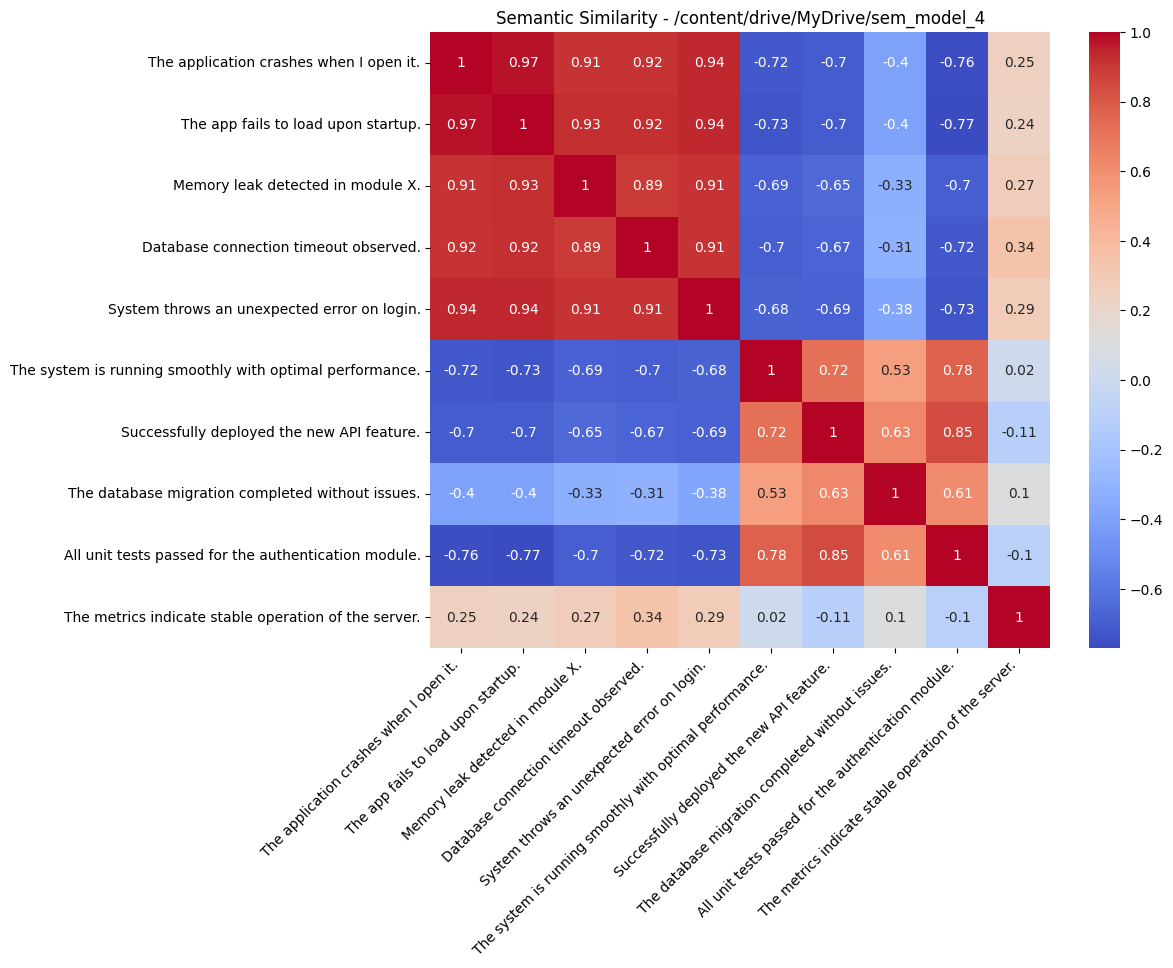


📌 Model: /content/drive/MyDrive/sem_model_4
📊 Metrics: {'accuracy': 0.9, 'precision': 0.8333333333333334, 'recall': 1.0, 'f1': 0.9090909090909091}


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# List of model paths to test
model_paths = [
    "/content/drive/MyDrive/sem_model_4",
]

# Test sentences (Bug reports + Non-bug technical sentences)
test_sentences = [
    "The application crashes when I open it.",
    "The app fails to load upon startup.",
    "Memory leak detected in module X.",
    "Database connection timeout observed.",
    "System throws an unexpected error on login.",
    "The system is running smoothly with optimal performance.",
    "Successfully deployed the new API feature.",
    "The database migration completed without issues.",
    "All unit tests passed for the authentication module.",
    "The metrics indicate stable operation of the server."
]

# Labels: 1 for bugs, 0 for non-bugs
true_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

def load_model(model_path):
    """Load a model and tokenizer from a given path."""
    model = AutoModel.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

def compute_classification_metrics(model, tokenizer, sentences, true_labels):
    """Predict labels and compute classification metrics."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        logits = outputs.last_hidden_state.mean(dim=1)  # Mean pooling to get embeddings
        predicted_labels = (logits[:, 0] > 0).int().cpu().tolist()  # Binary classification assumption
        predictions.extend(predicted_labels)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def calculate_semantic_similarity(model, tokenizer, sentences):
    """Compute semantic similarity between sentences using embeddings."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

    embeddings_np = embeddings.cpu().numpy()
    return cosine_similarity(embeddings_np)

# Iterate over all given models
results = {}
for model_path in model_paths:
    print(f"\n🔍 Testing Model: {model_path}")

    # Load model and tokenizer
    model, tokenizer = load_model(model_path)

    # Compute classification metrics
    metrics = compute_classification_metrics(model, tokenizer, test_sentences, true_labels)
    print("✅ Classification Metrics:", metrics)

    # Compute similarity matrix
    similarity_matrix = calculate_semantic_similarity(model, tokenizer, test_sentences)

    # Store results
    results[model_path] = {"metrics": metrics, "similarity_matrix": similarity_matrix}

    # Plot similarity heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", xticklabels=test_sentences, yticklabels=test_sentences)
    plt.title(f"Semantic Similarity - {model_path}")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# Compare results across models
for model_name, data in results.items():
    print(f"\n📌 Model: {model_name}")
    print("📊 Metrics:", data["metrics"])


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy model to Google Drive
shutil.copytree("/content/drive/MyDrive/model4_eclipse", "/content/drive/MyDrive/sem_model_4")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/sem_model_4'

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the model and tokenizer manually
model_path = "/content/drive/MyDrive/sem_model_4"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize the input sentences
inputs = tokenizer([sentence1, sentence2, sentence3], padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract embeddings (usually from the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

print(embeddings.shape)  # Should print [3, hidden_size]


torch.Size([3, 384])


In [ ]:
import numpy as np
embeddings_np = embeddings.cpu().numpy()
print(embeddings_np.shape)  # Should output (3, 384)


(3, 384)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)
print(similarity_matrix)


[[1.0000001  0.97026354 0.31287748]
 [0.97026354 1.0000001  0.3201636 ]
 [0.31287748 0.3201636  0.9999999 ]]


In [ ]:
import gensim
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the Gensim model
model_path = "/content/drive/MyDrive/bugreport-vectors-gensim-sg500d_5w_5m.bin"
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize sentences into words (simple whitespace tokenization here)
sentences = [sentence1.split(), sentence2.split(), sentence3.split()]

# Get the embeddings for each sentence
def get_sentence_embedding(sentence, model):
    # Average the embeddings for the words in the sentence
    embeddings = [model[word] for word in sentence if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Return the mean embedding as a numpy array
    else:
        return np.zeros(model.vector_size)  # If no words in sentence, return a zero vector

# Calculate embeddings for each sentence
sentence_embeddings = np.array([get_sentence_embedding(sentence, gensim_model) for sentence in sentences])

# Print the shape of the embeddings
print("Embeddings shape:", sentence_embeddings.shape)  # Should print (3, embedding_dim)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(sentence_embeddings)

# Print similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)


Embeddings shape: (3, 500)
Cosine Similarity Matrix:
[[1.0000001  0.65559745 0.26586387]
 [0.65559745 0.9999999  0.26925582]
 [0.26586387 0.26925582 1.0000001 ]]
